# 1. Понимание бизнеса
## 1.1 Цель
Нашей задачей является определение качества вина по некоторым входным данным
## 1.2 Описание проблемы
Употребление некачественного алкоголя может привести к различным проблемам со здоровьем, включая отравление, печеночную недостаточность, нарушение сердечно-сосудистой системы, слабость, потерю сознания и даже смерть. Поэтому очень важно следить за качеством употребляемого спиртного напитка.
## 1.3 Подключение библиотек

In [553]:
# Основные библиотеки для работы с датасетами
import pandas as pd
import numpy as np

# Модели
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, IsolationForest

# Вспомогательные элементы
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from math import ceil

# Метрики
from sklearn.metrics import classification_report, roc_auc_score, r2_score

# Визуализация данных
import seaborn as sns
import matplotlib.pyplot as plt

# Библиотека для нейронных сетей
import torch
import torch.nn as nn
import torch.optim as optim

# Библиотеки для выгрузки и загурзки модели
import joblib
import os

## 1.4 Вспомогательные функции

In [557]:
# Функция для вовода матрицы корреляций
def corr_matrix(dataframe: pd.DataFrame, figsize=(11, 9)):
  plt.figure(figsize=figsize)
  sns.heatmap(dataframe.corr(), annot=True)
  plt.show()

# Функция для вывода "ящика с усами для определнного столбца"
def box_plot(column: pd.Series, figsize=(11, 9)):
  plt.figure(figsize=figsize)
  plt.boxplot(column)
  plt.show()

def hist(dataset: pd.DataFrame, categorical_columns: list, target: str, target_value,figsize=(11, 9)):
  values = dataset[dataset[target] == target_value]
  plt.figure(figsize=figsize)
  for column in categorical_columns:
    plt.hist(dataset[column])
    plt.show()

def value_cahnger(frame: pd.DataFrame):
  for column in frame:
    mean = frame[column].mean()
    is_null = frame[column].isnull()
    frame[column].iloc[is_null] = mean

def plot_features_scores(model, data, target, column_names, model_type):
    model.fit(data, target)
    if model_type == 'rf':
        (pd.DataFrame(data={'score': model.feature_importances_}, 
                      index=column_names).sort_values(by='score')
                                         .plot(kind='barh', grid=True,
                                               figsize=(6,6), legend=False));
    elif model_type == 'lr':
        (pd.DataFrame(data={'score': model.coef_[0]},
                      index=column_names).sort_values(by='score')
                                         .plot(kind='barh', grid=True,
                                               figsize=(6,6), legend=False));
    
    else:
        raise KeyError('Unknown model_type')

def load_model(filename: str):
  m = loaded_rf = joblib.load('./' + filename)
  print('Модель была загружена!')
  return m

def save_model(rf, filename: str):
  joblib.dump(rf, './' + filename)
  print('Модель была выгружена!')

## Загрузка данных

In [363]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [364]:
# Для скачивания воспользуемся библиотекой opendatasets, которая позволит автматически загрузить наш датасет, используя токен kaggle
import opendatasets as od

In [365]:
od.download(dataset_id_or_url='https://www.kaggle.com/datasets/rajyellow46/wine-quality')

Skipping, found downloaded files in "./wine-quality" (use force=True to force download)


In [366]:
dataset = pd.read_csv('/content/wine-quality/winequalityN.csv')

In [367]:
dataset.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


# Описание признаков
type - тип вина



*   fixed acidity - фиксированная кислотность
*   volatile acidity - летучая кислотность
*   citric acid - лимонная кислота
*   residual sugar - остаточный сахар
*   сhlorides - хлориды
*   free sulfur dioxide - свободный диоксид серы
*   total sulfur dioxide - общий диоксид серы
*   density - плотность
*   pH - рН (водородный показатель)
*   sulphates - сульфаты
*   alcohol - спирт
*   quality (score between 0 and 10) - качество (оценка от 0 до 10)

Изучим содержимое датасета

Первое, что брасается в глаза - это то, что в некоторых колонках есть пропуски.

Вторым замечанием будет сильное нарушение верхних границ по некоторым из параметров, например, total SO2 и free SO2 (sugar dioxide).

Также один из параметров представлен в строковом формате, значит его необходимо перевести в числовой. 

In [368]:
dataset.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [369]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


<ipython-input-362-b4b84e050051>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(dataframe.corr(), annot=True)


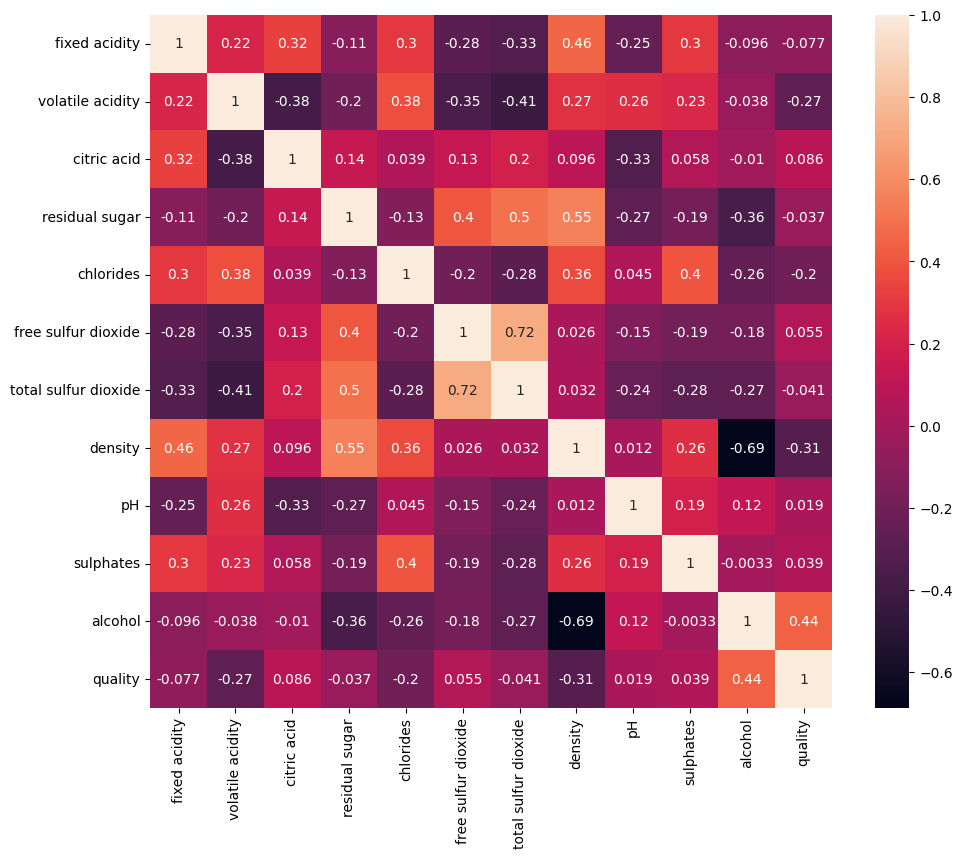

In [370]:
corr_matrix(dataset)

Как видно из построенной матрицы корреляции, все параметры достаточно сильно взаимосвязаны (это вполне логично). На оценку продукции больше всего влияет процентное содержание алкоголя в вине.

# 3 Подготовка данных
## 3.1 Кодирование категориальных данных

In [371]:
# Перекодируем стороковый столбец через LableEncoder
# 1 - White, 2 - Red
encoder = LabelEncoder()
dataset['type'] = encoder.fit_transform(dataset['type'])

In [381]:
dataset.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,1,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,1,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,1,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,1,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [382]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   int64  
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 660.0 KB


## 3.2 Анализ и удаление выбросов и дубликатов

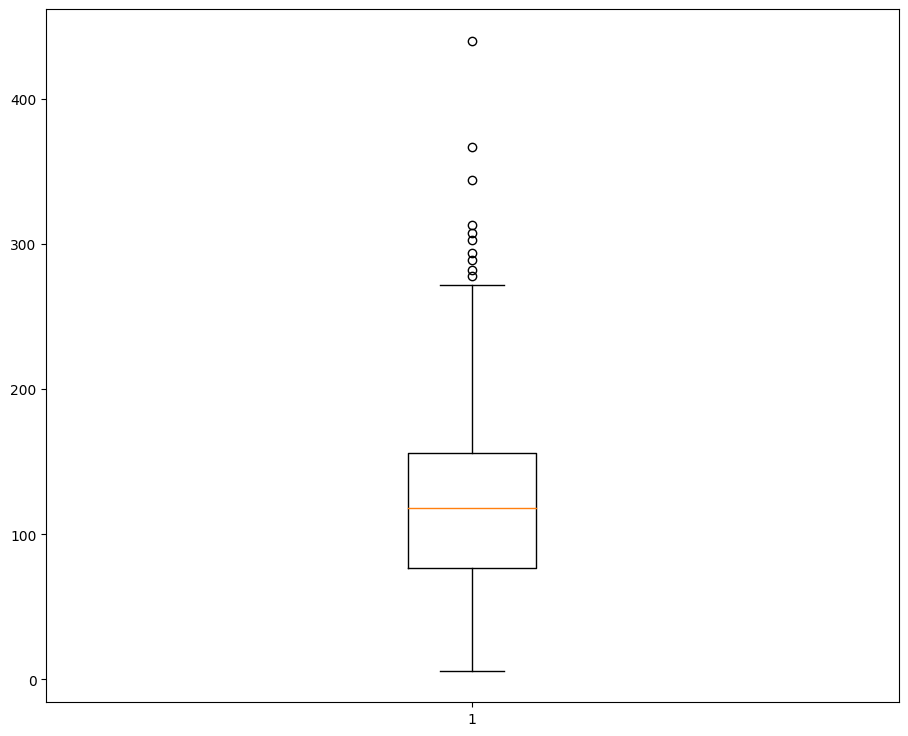

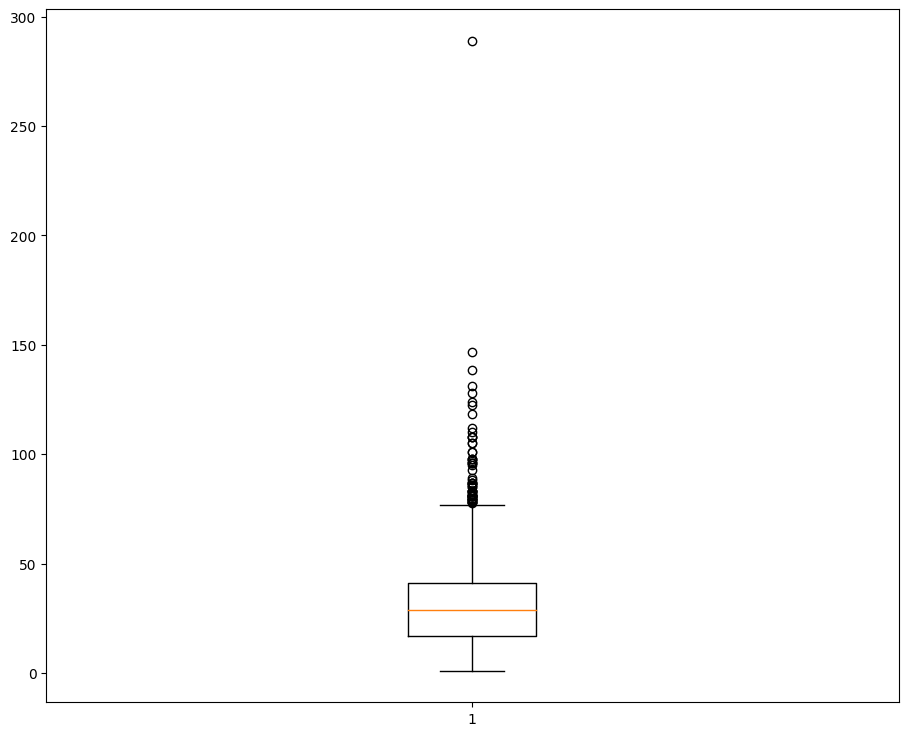

(None, None)

In [383]:
# Необходимо провести нормализацию данных но перед этим нужно посмотреть на выбросы 
box_plot(dataset['total sulfur dioxide']), box_plot(dataset['free sulfur dioxide'])

Теперь когда мы увидели сильные выбросы, давайте уберем его

In [384]:
dataset[dataset['total sulfur dioxide'] > 400]

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
4745,1,6.1,0.26,0.25,2.9,0.047,289.0,440.0,0.99314,3.44,0.64,10.5,3


In [385]:
new_ds = dataset.drop(4745, axis=0)
new_ds = new_ds.drop('total sulfur dioxide', axis=1)
new_ds.drop_duplicates(inplace=True)

После удаления выброса, колонки, которая, по-моему мнению, сильно коррелирует с другой похожей, а также избавления от дубликатов, можно посмотреть распределение категориальных переменных в зависимости от качества

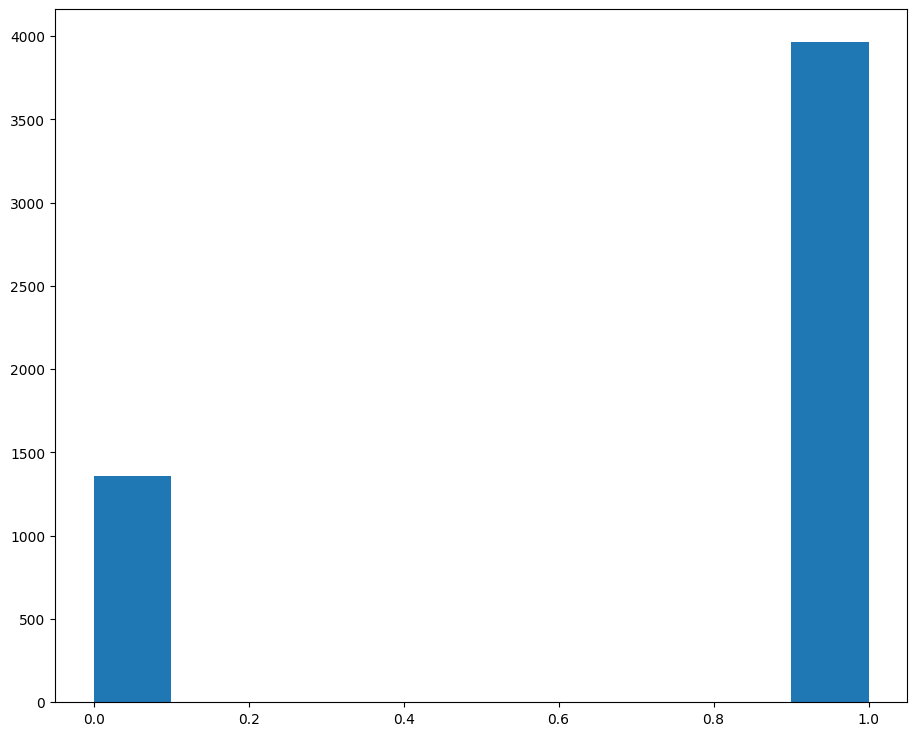

In [387]:
hist(new_ds, ['type'], 'quality', 6)

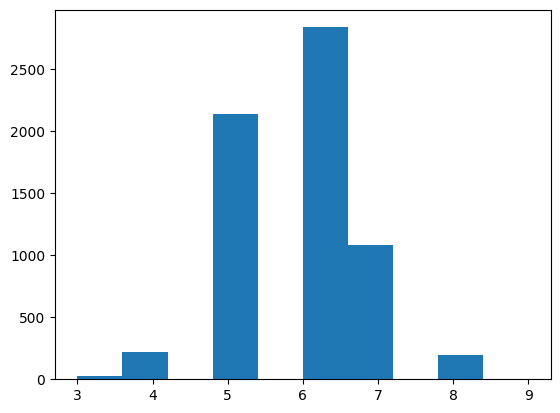

In [388]:
plt.hist(dataset['quality'])
plt.show()

Посмотрев распределение качества, довольно очевидным становится, что в датасете присутствует сильный дисбаланс классов, к сожалению, с этим ничего не сделать, ведь это нормально, что в среднем оценка получается в районе 5-7, а все, что выше или ниже намного реже 

# 3.3 Заполнение пропусков

In [389]:
# Заполним пропуски средними значениями, предварительно разделив вина по типам.
type_w, type_r = new_ds[new_ds['type'] == 1], new_ds[new_ds['type'] == 0]

In [390]:
dataset[(dataset['quality'] == 5) | (dataset['quality'] == 6)].shape[0] / dataset.shape[0]

0.7655841157457288

In [391]:
value_cahnger(type_w)
value_cahnger(type_r)

<ipython-input-362-b4b84e050051>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[column].iloc[is_null] = mean


In [392]:
type_r.describe()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1358.0,1358.000000,1358.000000,1358.000000,1358.000000,1358.000000,1358.000000,1358.000000,1358.000000,1358.000000,1358.000000,1358.000000
mean,0.0,8.313791,0.529550,0.272233,2.519146,0.088152,15.877393,0.996712,3.309712,0.658732,10.430940,5.622239
std,0.0,1.735933,0.182958,0.195155,1.343686,0.049384,10.434635,0.001867,0.154650,0.170660,1.081275,0.823033
min,0.0,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,0.0,7.100000,0.390000,0.092500,1.900000,0.070000,7.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,0.0,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,0.996700,3.310000,0.620000,10.200000,6.000000
75%,0.0,9.200000,0.640000,0.430000,2.600000,0.091000,21.000000,0.997820,3.400000,0.730000,11.100000,6.000000
max,0.0,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [393]:
type_w.describe()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,density,pH,sulphates,alcohol,quality
count,3963.0,3963.000000,3963.000000,3963.000000,3963.000000,3963.000000,3963.000000,3963.000000,3963.000000,3963.00000,3963.000000,3963.000000
mean,1.0,6.841049,0.280705,0.334481,5.913481,0.045890,34.811885,0.993787,3.195359,0.49029,10.590019,5.855665
std,0.0,0.865906,0.103542,0.122454,4.861094,0.023099,16.724808,0.002904,0.151381,0.11353,1.217488,0.890162
min,1.0,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,0.987110,2.720000,0.22000,8.000000,3.000000
25%,1.0,6.300000,0.210000,0.270000,1.600000,0.035000,23.000000,0.991615,3.090000,0.41000,9.500000,5.000000
50%,1.0,6.800000,0.260000,0.320000,4.700000,0.042000,33.000000,0.993500,3.180000,0.48000,10.400000,6.000000
75%,1.0,7.300000,0.330000,0.390000,8.800000,0.050000,45.000000,0.995700,3.290000,0.55000,11.400000,6.000000
max,1.0,14.200000,1.100000,1.660000,65.800000,0.346000,146.500000,1.038980,3.820000,1.08000,14.200000,9.000000


In [394]:
new_ds = pd.concat([type_w, type_r])

In [395]:
new_ds.describe()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,density,pH,sulphates,alcohol,quality
count,5321.000000,5321.000000,5321.000000,5321.000000,5321.000000,5321.000000,5321.000000,5321.000000,5321.000000,5321.000000,5321.000000,5321.000000
mean,0.744785,7.216915,0.344214,0.318594,5.047195,0.056676,29.979515,0.994533,3.224544,0.533279,10.549420,5.796091
std,0.436023,1.318869,0.168212,0.147033,4.499918,0.036865,17.442754,0.002966,0.160166,0.149740,1.186145,0.879354
min,0.000000,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,0.000000,6.400000,0.230000,0.240000,1.800000,0.038000,16.000000,0.992200,3.120000,0.430000,9.500000,5.000000
50%,1.000000,7.000000,0.300000,0.310000,2.700000,0.047000,28.000000,0.994640,3.210000,0.510000,10.400000,6.000000
75%,1.000000,7.700000,0.410000,0.400000,7.500000,0.066000,41.000000,0.996760,3.330000,0.600000,11.400000,6.000000
max,1.000000,15.900000,1.580000,1.660000,65.800000,0.611000,146.500000,1.038980,4.010000,2.000000,14.900000,9.000000


# 3.4 Важность признаков

In [396]:
rf = RandomForestClassifier(n_jobs=-1, random_state=42)

In [397]:
x, y = new_ds.drop('quality', axis=1), new_ds['quality']

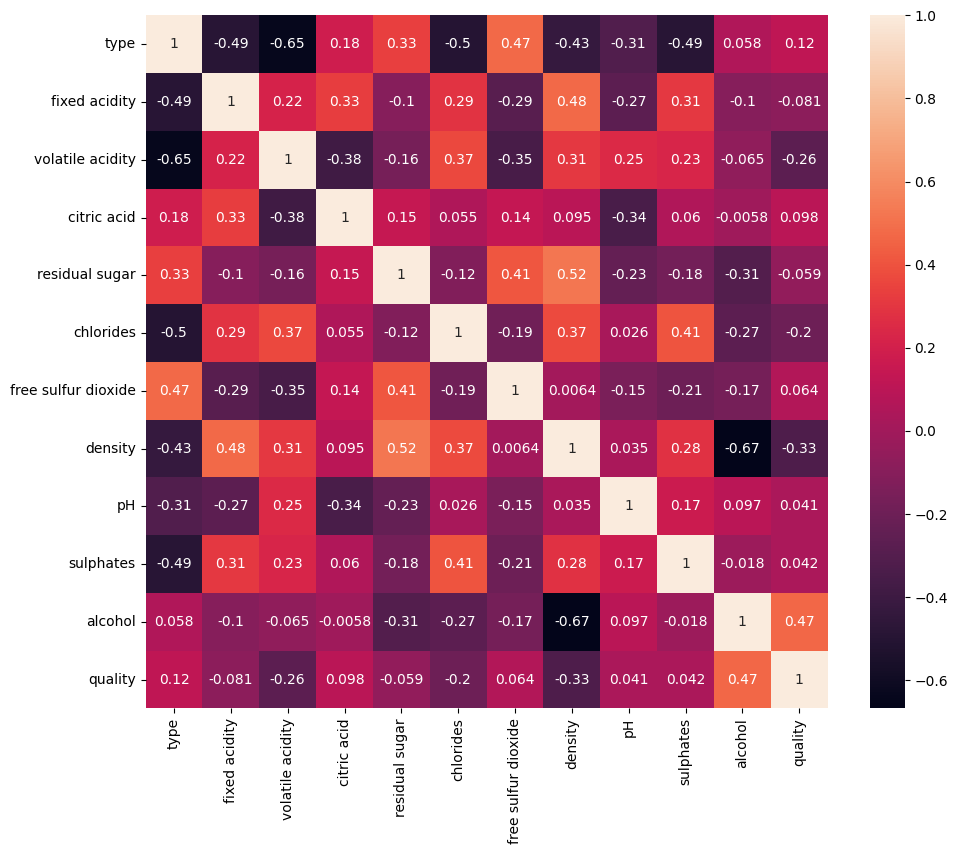

In [398]:
corr_matrix(new_ds)

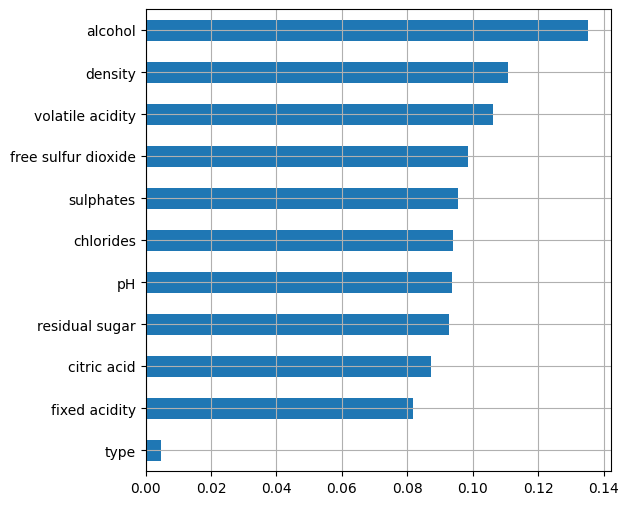

In [399]:
# Посмотрим на важность признаков
plot_features_scores(model=rf, data=x, target=y, column_names=x.columns, model_type='rf')

Так как тип оказался не очень важным признаком, считаю, что можно удалить его, помиммо этого данные находятся в разном масштабе, поэтому их необходимо нормализовать. Сделаем это при помощи **MinMaxScaler**

In [401]:
minmax_scale = MinMaxScaler()
end_ds = new_ds.drop('type', axis=1)
x, y = end_ds.drop('quality', axis=1), end_ds['quality']
x = minmax_scale.fit_transform(x)

In [408]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# 4 Моделирование
В качестве моделей были взяты классификатор на случайном лесе, а также нейронная сеть с выходным SoftMax. 

In [550]:
n_epochs = 50
batch_size = 5
batches_per_epoch = len(x_train)

In [410]:
best_score, best_model = -1, None
for epoch in range(n_epochs):
  rf = RandomForestClassifier()
  rf.fit(x_train, y_train)
  if rf.score(x_test, y_test) > best_score:
    best_model = rf
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=epoch)

In [411]:
best_model.score(x_test, y_test)

0.9117370892018779

In [551]:
y_pred = best_model.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         3.0       1.00      0.60      0.75         5
         4.0       1.00      0.81      0.89        42
         5.0       0.95      0.92      0.93       345
         6.0       0.88      0.96      0.91       478
         7.0       0.92      0.85      0.89       168
         8.0       1.00      0.65      0.79        26
         9.0       1.00      1.00      1.00         1

    accuracy                           0.91      1065
   macro avg       0.96      0.83      0.88      1065
weighted avg       0.92      0.91      0.91      1065



После нескольких попыток, мы получили очень высокий результат, но возможно стоит попробовать нейросеть

In [531]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Net, self).__init__()
        
        # Input layer, input_size = number of features
        self.fc1 = nn.Linear(input_size, hidden_size)
        # Use ReLU Activation Function, hidden layer
        self.relu = nn.ReLU()
        # Output layer and softmax after
        self.fc2 = nn.Linear(hidden_size, 1)
    
    # Calculating output value
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [543]:
input_size = x_train.shape[1]
hidden_size = 3 * input_size
learning_rate = 1e-3

In [544]:
model = Net(input_size, hidden_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [545]:
for epoch in range(n_epochs):
    optimizer.zero_grad()
    output = model(torch.tensor(x_train).float())
    loss = criterion(output.float(), torch.tensor(y_train.values).float())
    loss.backward()
    optimizer.step()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([4256])) that is different to the input size (torch.Size([4256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [548]:
with torch.no_grad():
  output = model(torch.tensor(x_test).float())

In [549]:
y_pred = pd.Series([el.item() for el in output])
r2_score(y_test, y_pred)

-0.27678844847029005

По итогам нейросеть вообзе не справилась с задачей

В качестве интегрируемой модели необходимо взять модель случайного леса, набравшую внушающие результаты

# 5 Выгрузка модели

In [556]:
save_model(best_model, 'best_RF_model')

Модель была выгружена!
